[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\yogesh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yogesh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yogesh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

Train on 11412 samples, validate on 1269 samples
Epoch 1/5
11412/11412 [==============================] - 27s 2ms/step - loss: 0.2860 - accuracy: 0.8973 - val_loss: 0.0876 - val_accuracy: 0.9756
Epoch 2/5
11412/11412 [==============================] - 23s 2ms/step - loss: 0.0605 - accuracy: 0.9848 - val_loss: 0.0902 - val_accuracy: 0.9771
Epoch 3/5
11412/11412 [==============================] - 24s 2ms/step - loss: 0.0411 - accuracy: 0.9885 - val_loss: 0.0996 - val_accuracy: 0.9764
Epoch 4/5
11412/11412 [==============================] - 22s 2ms/step - loss: 0.0291 - accuracy: 0.9925 - val_loss: 0.1130 - val_accuracy: 0.9756


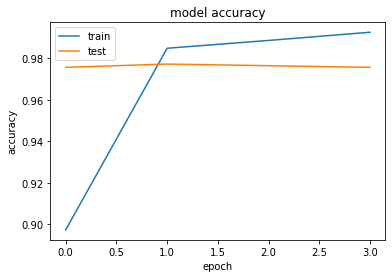

None
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      2548
           1       1.00      0.96      0.98      1679

    accuracy                           0.98      4227
   macro avg       0.99      0.98      0.98      4227
weighted avg       0.98      0.98      0.98      4227



In [2]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from keras.preprocessing import sequence
import sklearn
import keras
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from keras import models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder 
import matplotlib.pyplot as plt
from keras.layers import Dense, Dropout, LSTM, Embedding, SpatialDropout1D 
from keras.callbacks.callbacks import EarlyStopping
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

sw = set(stopwords.words('english'))
ps = PorterStemmer()

def clean_review(text):
    text = str(text)
    text = text.lower()
    text = text.replace('<br /><br />', '')
    text = re.sub('[^a-z]+', ' ', text)
    text = text.split()
    text = [ps.stem(w) for w in text if w not in sw]
    text = ' '.join(text)
    return text

def normalize_data(tokenized_reviews, vocab):
    X = []
    for i in range(0, len(tokenized_reviews)):
        p = []
        for j in tokenized_reviews[i]:
            if j in vocab.keys():
                p.append(vocab[j])
        X.append(p)
    return X


class RecurrentNeuralNetwork:
    
    def __init__(self, df, max_features):
        self.__df = df[['Text', 'label']]
        self.__split_dataset()
        self.__clean_dataset()
        train_text = self.__df_train['cleaned_text'].values
        test_text = self.__df_test['cleaned_text'].values
        
        # Build a vocabulary
        self.__cv = CountVectorizer(max_features = max_features)
        self.__cv.fit_transform(train_text)
        self.__cv.transform(test_text)
        
        tokenized_train_text = [i.split() for i in train_text]
        tokenized_test_text = [i.split() for i in test_text]
        
        self.__X_train = normalize_data(tokenized_train_text, self.__cv.vocabulary_)
        self.__X_test = normalize_data(tokenized_test_text, self.__cv.vocabulary_)
        
        maxlen = 100
        self.__X_train = sequence.pad_sequences(self.__X_train, maxlen = maxlen)
        self.__X_test = sequence.pad_sequences(self.__X_test, maxlen = maxlen)
        
        self.__y_train = self.__convertOneHot(self.__y_train)
        self.__y_test = self.__convertOneHot(self.__y_test)
        
    def __split_dataset(self):
        labels = self.__df['label']
        self.__df_train, self.__df_test, self.__y_train, self.__y_test = train_test_split(self.__df, 
                                                                                          labels, 
                                                                                          test_size = 0.25)
    def __clean_dataset(self):
        self.__df_train['cleaned_text'] = self.__df_train['Text'].apply(clean_review)
        self.__df_test['cleaned_text'] = self.__df_test['Text'].apply(clean_review)
        
    def __convertOneHot(self, y):
        return keras.utils.to_categorical(y, num_classes = 3)
    
    def create_model(self, MAX_NB_WORDS, EMBEDDING_DIM):
        self.__model = models.Sequential()
        self.__model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length = self.__X_train.shape[1]))
        self.__model.add(LSTM(64, dropout = 0.3, recurrent_dropout = 0.3))
        self.__model.add(Dense(3, activation='softmax'))
        self.__model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
        
    def fit_model(self, epochs, batch_size):
        self.__history = self.__model.fit(self.__X_train, self.__y_train, 
                    epochs = epochs, 
                    batch_size = batch_size, 
                    validation_split = 0.1, 
                    callbacks = [EarlyStopping(monitor = 'val_loss', patience = 3, min_delta = 0.0001)]
                   )

    def predict(self):
        pred = self.__model.predict(self.__X_test)
        return pred
    
    def evaluate(self):
        loss, accuracy = self.__model.evaluate(self.__X_test, self.__y_test)
        return (accuracy * 100)
    
    def get_y_test(self):
        return self.__y_test
    
    def plot(self):
        plt.plot(self.__history.history['accuracy'])
        plt.plot(self.__history.history['val_accuracy'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc = 'upper left')
        plt.show()


df = pd.read_csv('Desktop/Twitter_Sarcasm_Dataset.csv')
max_features = 6500
EMBEDDING_DIM = 100
epochs = 5
batch_size = 64
model = RecurrentNeuralNetwork(df, max_features)
model.create_model(max_features, EMBEDDING_DIM)
model.fit_model(epochs, batch_size)
# prediction = model.predict()
# accuracy = model.evaluate()
y_pred = model.predict()
y_test = model.get_y_test()
y_test = np.argmax(y_test, axis = 1)
y_pred = np.argmax(y_pred, axis = 1)
print(model.plot())
print(classification_report(y_test, y_pred))

In [1]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import sklearn
import keras
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

sw = set(stopwords.words('english'))
ps = PorterStemmer()

def clean_review(text):
    text = str(text)
    text = text.lower()
    text = text.replace('<br /><br />', '')
    text = re.sub('[^a-z]+', ' ', text)
    text = text.split()
    text = [ps.stem(w) for w in text if w not in sw]
    text = ' '.join(text)
    return text

class NaiveBayes:
    
    def __init__(self, df):
        
        self.__df = df[['Text', 'label']]
        self.__splitDataset()
        self.__CleanDataset()
        train_text = self.__df_train['cleaned_text'].values
        test_text = self.__df_test['cleaned_text'].values
                
        training_reviews = self.__df_train['cleaned_text'].values
        test_reviews = self.__df_test['cleaned_text'].values
        
        self.cv = CountVectorizer()
        
        self.__getTrainingData(training_reviews)
        self.__getTestingData(test_reviews)
        
      
    def __splitDataset(self):
        labels = self.__df['label']
        self.__df_train, self.__df_test, self.__y_train, self.__y_test = train_test_split(self.__df, 
                                                                                          labels, 
                                                                                          test_size = 0.25)
#         self.__s_train = y_train.values
#         self.__s_test = y_test.values
        
    def __CleanDataset(self):
        self.__df_train['cleaned_text'] = self.__df_train['Text'].apply(clean_review)
        self.__df_test['cleaned_text'] = self.__df_test['Text'].apply(clean_review)
#         self.__amazon_df_train = self.__amazon_df_train[['cleaned_review', 'labels']]
#         self.__amazon_df_test = self.__amazon_df_test[['cleaned_review', 'labels']]
    
    def __getTrainingData(self, training_reviews):
        self.__X_train = self.cv.fit_transform(training_reviews)
        
    def __getTestingData(self, test_reviews):
        self.__X_test = self.cv.transform(test_reviews)
        
    def predict(self):
        self.mnb = MultinomialNB()
        self.mnb.fit(self.__X_train, self.__y_train)
        self.__pred = self.mnb.predict(self.__X_test)
        return self.__pred
    
    def get_y_test(self):
        return self.__y_test

    def get_dataset(self):
        return self.__df

# Model
df = pd.read_csv('Desktop/Twitter_Sarcasm_Dataset.csv')
model = NaiveBayes(df)
y_pred = model.predict()
y_test = model.get_y_test()
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1_score = f1_score(y_test, y_pred)
print(accuracy)
print(precision)
print(recall)
print(f1_score)

Using TensorFlow backend.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\yogesh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yogesh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yogesh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

0.9588360539389638
0.9412484700122399
0.9517326732673267
0.9464615384615385


In [6]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import sklearn
import keras
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder, MaxAbsScaler
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

sw = set(stopwords.words('english'))
ps = PorterStemmer()

def clean_review(text):
    text = str(text)
    text = text.lower()
    text = text.replace('<br /><br />', '')
    text = re.sub('[^a-z]+', ' ', text)
    text = text.split()
    text = [ps.stem(w) for w in text if w not in sw]
    text = ' '.join(text)
    return text

class KNearestNeighbours:
    
    def __init__(self, df, K):
        
        self.__K = K
        self.__df = df[['Text', 'label']]
        self.__splitDataset()
        self.__CleanDataset()
        train_text = self.__df_train['cleaned_text'].values
        test_text = self.__df_test['cleaned_text'].values
                
        training_reviews = self.__df_train['cleaned_text'].values
        test_reviews = self.__df_test['cleaned_text'].values
        
        self.cv = CountVectorizer()
        self.tfidf = TfidfTransformer()
        
        self.__getTrainingData(training_reviews)
        self.__getTestingData(test_reviews)
        
      
    def __splitDataset(self):
        labels = self.__df['label']
        self.__df_train, self.__df_test, self.__y_train, self.__y_test = train_test_split(self.__df, 
                                                                                          labels, 
                                                                                          test_size = 0.25)

    def __CleanDataset(self):
        self.__df_train['cleaned_text'] = self.__df_train['Text'].apply(clean_review)
        self.__df_test['cleaned_text'] = self.__df_test['Text'].apply(clean_review)

    def __getTrainingData(self, training_reviews):
        self.__X_train = self.cv.fit_transform(training_reviews)
        
    def __getTestingData(self, test_reviews):
        self.__X_test = self.cv.transform(test_reviews)
        
    def predict(self):
        self.knn = KNeighborsClassifier(n_neighbors = self.__K)
        self.knn.fit(self.__X_train, self.__y_train)
        pred = self.knn.predict(self.__X_test)
        self.__pred = pred
        return pred
    
    def get_y_test(self):
        return self.__y_test

    def get_dataset(self):
        return self.__df

# Model
df = pd.read_csv('Desktop/Twitter_Sarcasm_Dataset.csv')
K = 20
model = KNearestNeighbours(df, K)
y_pred = model.predict()
y_test = model.get_y_test()
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1_score = f1_score(y_test, y_pred)
print(accuracy)
print(precision)
print(recall)
print(f1_score)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\yogesh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yogesh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yogesh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

0.9751596877217885
0.9993634627625716
0.937873357228196
0.9676425269645608
